# Parallelization of Non-Negative Matrix Factorization with CUDA

TODO: Intro description here

## Import Modules

In [10]:
import time
import numpy as np

from src.data_utils import get_matrices, get_topics, plot_execution_times, get_n_matrices, plot_loss
from src.nmf import NMF_serial, NMF_parallel, NMF_sklearn

# reload modules every 2 seconds (to see changes)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
# define number of topics to extract from data
num_topics = 25

# define X, W, H matrices
X, W, H = get_matrices(num_topics)

print("X: ", X.shape, ": number of articles = {}, number of unique words = {}".format(X.shape[0], X.shape[1]))
print("W: ", W.shape, ": number of articles = {}, number of topics = {}".format(W.shape[0], W.shape[1]))
print("H: ", H.shape, ": number of topics = {}, number of unique words = {}".format(H.shape[0], H.shape[1]))


X:  (3012, 8447) : number of articles = 3012, number of unique words = 8447
W:  (3012, 25) : number of articles = 3012, number of topics = 25
H:  (25, 8447) : number of topics = 25, number of unique words = 8447


## NMF with Euclidean Multiplicative Updates

TODO: maybe some descriptions here

### Serial Euclidean NMF with Python

In [5]:
num_iterations = 100
W_serial, H_serial, losses_serial, time_serial = NMF_serial(X, W, H)

print("{} iterations of serial Euclidean NMF completed in {} s.".format(num_iterations, round(time_serial, 3)))

Starting 100 iterations of serial NMF with euclidean loss.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of serial Euclidean NMF completed in 44.524 s.


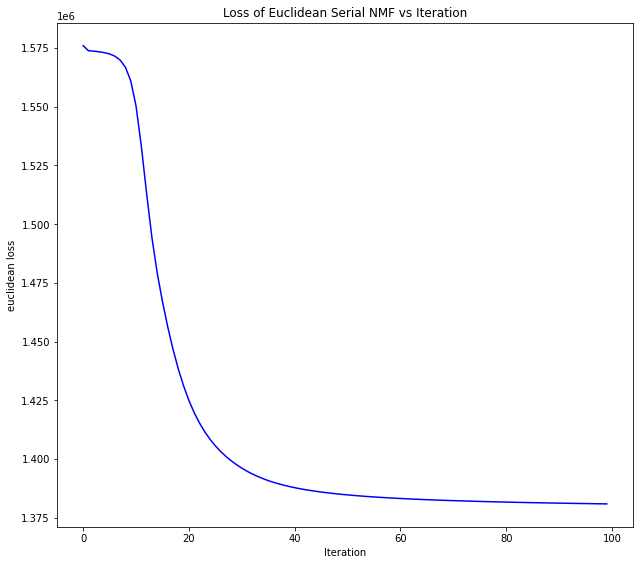

In [4]:
# visualize loss 
title = "Loss of Euclidean Serial NMF vs Iteration"
plot_loss(losses_serial, title)

In [18]:
# Visualize results
get_topics(W_serial, print_results=False) # NOTE: change W_serial --> W to see initial topics

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0240 percent,0.0623 states,0.0198 campaign,0.0421 father,0.0098 mile,0.0195 official,0.0263 pay,0.0146 company,0.0239 music,0.0202 second,...,0.0129 art,0.0107 serve,0.0161 question,0.0218 film,0.0192 building,0.0402 company,0.0194 thing,0.0282 case,0.0245 play,0.0129 public
1,0.0197 rate,0.0546 american,0.0180 vote,0.0382 graduate,0.0078 water,0.0134 force,0.0194 member,0.0137 computer,0.0128 performance,0.0201 hit,...,0.0097 artist,0.0097 add,0.0121 ask,0.0175 movie,0.0185 city,0.0296 executive,0.0138 tell,0.0218 court,0.0241 team,0.0093 change
2,0.0159 increase,0.0426 country,0.0179 political,0.0294 son,0.0075 hour,0.0132 military,0.0159 worker,0.0111 system,0.0126 play,0.0169 third,...,0.0077 exhibition,0.0091 minute,0.0102 report,0.0168 play,0.0131 house,0.0217 president,0.0133 ask,0.0214 lawyer,0.0240 game,0.0091 issue
3,0.0155 rise,0.0236 world,0.0175 party,0.0293 school,0.0073 car,0.0131 government,0.0159 money,0.0097 service,0.0111 perform,0.0149 start,...,0.0070 painting,0.0088 pepper,0.0093 issue,0.0140 television,0.0131 build,0.0204 business,0.0118 lot,0.0172 law,0.0190 player,0.0084 power
4,0.0133 economy,0.0150 americans,0.0168 election,0.0279 mrs,0.0068 place,0.0111 leader,0.0144 job,0.0096 technology,0.0105 song,0.0140 win,...,0.0064 museum,0.0087 food,0.0078 write,0.0120 director,0.0120 area,0.0191 chief,0.0114 feel,0.0144 state,0.0164 season,0.0078 policy
5,0.0123 report,0.0135 international,0.0164 republican,0.0261 daughter,0.0063 drive,0.0104 war,0.0136 union,0.0087 sell,0.0100 concert,0.0136 game,...,0.0061 collection,0.0084 oil,0.0077 tell,0.0118 character,0.0104 home,0.0138 chairman,0.0093 really,0.0143 judge,0.0140 point,0.0069 political
6,0.0113 low,0.0133 foreign,0.0163 candidate,0.0244 mother,0.0057 line,0.0083 troop,0.0119 law,0.0078 customer,0.0095 dance,0.0131 inning,...,0.0057 early,0.0083 cook,0.0071 interview,0.0103 production,0.0099 community,0.0112 vice,0.0090 start,0.0137 charge,0.0135 win,0.0062 problem
7,0.0111 economic,0.0098 nation,0.0144 democratic,0.0214 student,0.0056 foot,0.0076 peace,0.0116 service,0.0077 information,0.0093 night,0.0123 pitch,...,0.0055 form,0.0082 cup,0.0064 meeting,0.0097 star,0.0096 live,0.0104 industry,0.0086 put,0.0115 trial,0.0116 coach,0.0057 system
8,0.0102 growth,0.0098 european,0.0135 leader,0.0201 receive,0.0055 area,0.0074 attack,0.0114 official,0.0076 offer,0.0092 program,0.0123 home,...,0.0055 design,0.0080 sauce,0.0064 add,0.0091 actor,0.0096 resident,0.0093 large,0.0083 little,0.0108 legal,0.0097 second,0.0056 believe
9,0.0085 decline,0.0093 trade,0.0134 voter,0.0196 marry,0.0053 road,0.0070 agreement,0.0112 bill,0.0073 product,0.0084 sound,0.0116 victory,...,0.0054 view,0.0076 taste,0.0060 member,0.0085 direct,0.0092 site,0.0089 director,0.0082 keep,0.0094 file,0.0088 victory,0.0047 view


### Serial Euclidean NMF with Scikit-Learn

In [14]:
W_sklearn, H_sklearn, time_sklearn = NMF_sklearn(X, W, H, iterations=num_iterations, loss='euclidean')

print("{} iterations of sklearn Euclidean NMF completed in {} s.".format(num_iterations, round(time_sklearn, 3)))


Starting 100 iterations of Scikit-learn NMF with euclidean loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


100 iterations of sklearn Euclidean NMF completed in 23.193 s.


In [15]:
# Visualize results
get_topics(W_sklearn, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0344 percent,0.0549 states,0.0184 political,0.0528 school,0.0088 hour,0.0143 force,0.0594 official,0.0230 company,0.0243 music,0.0257 second,...,0.0134 art,0.0108 serve,0.0148 ask,0.0230 film,0.0191 building,0.0402 president,0.0249 thing,0.0282 case,0.0291 team,0.0102 public
1,0.0194 rate,0.0427 american,0.0182 campaign,0.0410 student,0.0079 mile,0.0142 military,0.0284 city,0.0134 computer,0.0127 performance,0.0187 third,...,0.0101 artist,0.0100 add,0.0130 question,0.0184 play,0.0148 city,0.0372 executive,0.0146 lot,0.0222 court,0.0276 play,0.0098 issue
2,0.0182 rise,0.0421 country,0.0168 vote,0.0217 child,0.0076 car,0.0121 official,0.0245 member,0.0103 service,0.0122 play,0.0182 hit,...,0.0081 exhibition,0.0090 minute,0.0123 tell,0.0182 movie,0.0143 build,0.0252 chief,0.0132 feel,0.0217 lawyer,0.0268 game,0.0097 change
3,0.0145 increase,0.0236 world,0.0163 party,0.0181 education,0.0061 drive,0.0121 war,0.0163 group,0.0101 system,0.0115 perform,0.0173 win,...,0.0072 painting,0.0090 pepper,0.0073 meeting,0.0135 television,0.0136 area,0.0215 company,0.0122 put,0.0196 law,0.0230 player,0.0083 problem
4,0.0139 price,0.0137 government,0.0154 election,0.0170 teacher,0.0060 night,0.0114 government,0.0152 agency,0.0097 technology,0.0108 song,0.0148 victory,...,0.0068 museum,0.0087 oil,0.0070 write,0.0133 character,0.0132 house,0.0207 vice,0.0115 really,0.0145 judge,0.0198 season,0.0072 system
5,0.0127 report,0.0137 foreign,0.0152 candidate,0.0161 parent,0.0060 line,0.0107 leader,0.0146 worker,0.0094 industry,0.0101 concert,0.0144 score,...,0.0064 collection,0.0087 food,0.0068 interview,0.0124 director,0.0108 home,0.0181 yesterday,0.0110 start,0.0133 charge,0.0142 point,0.0061 power
6,0.0126 market,0.0123 international,0.0150 republican,0.0161 college,0.0058 stop,0.0086 troop,0.0133 job,0.0086 product,0.0096 dance,0.0133 start,...,0.0058 early,0.0085 cook,0.0065 issue,0.0110 production,0.0102 resident,0.0176 director,0.0110 little,0.0128 state,0.0138 coach,0.0055 policy
7,0.0126 low,0.0118 americans,0.0133 democratic,0.0145 class,0.0058 place,0.0077 peace,0.0129 union,0.0086 customer,0.0092 night,0.0127 game,...,0.0056 design,0.0084 cup,0.0063 meet,0.0099 star,0.0098 project,0.0175 chairman,0.0107 big,0.0113 legal,0.0120 win,0.0048 point
8,0.0118 fall,0.0116 nation,0.0125 leader,0.0138 program,0.0054 trip,0.0077 attack,0.0110 problem,0.0084 business,0.0087 program,0.0116 home,...,0.0055 gallery,0.0081 sauce,0.0062 speak,0.0097 actor,0.0097 live,0.0141 name,0.0102 ask,0.0112 trial,0.0081 league,0.0046 mean
9,0.0110 point,0.0101 economic,0.0124 voter,0.0124 graduate,0.0054 water,0.0067 nations,0.0106 public,0.0081 sell,0.0085 sound,0.0106 lose,...,0.0055 view,0.0077 taste,0.0061 report,0.0092 direct,0.0093 site,0.0119 father,0.0101 keep,0.0096 file,0.0080 pass,0.0045 debate


### Parallel Euclidean NMF with CUDA

In [16]:
W_parallel, H_parallel, time_parallel = NMF_parallel(X, W, H)

print("{} iterations of parallel Euclidean NMF completed in {} s.".format(num_iterations, round(time_parallel, 3)))

Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of parallel Euclidean NMF completed in 1.025 s.


In [17]:
# Visualize results
get_topics(W_parallel, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0350 percent,0.0549 states,0.0183 political,0.0516 school,0.0088 hour,0.0147 force,0.0729 official,0.0245 company,0.0243 music,0.0261 second,...,0.0136 art,0.0108 serve,0.0161 ask,0.0224 film,0.0189 building,0.0449 president,0.0252 thing,0.0281 case,0.0319 team,0.0089 change
1,0.0196 rate,0.0431 american,0.0179 campaign,0.0402 student,0.0079 mile,0.0143 military,0.0232 city,0.0127 computer,0.0127 performance,0.0183 win,...,0.0103 artist,0.0100 add,0.0137 tell,0.0182 play,0.0167 city,0.0367 executive,0.0148 lot,0.0221 court,0.0289 play,0.0088 issue
2,0.0183 rise,0.0420 country,0.0166 vote,0.0204 child,0.0076 car,0.0123 war,0.0221 member,0.0101 industry,0.0121 play,0.0176 third,...,0.0083 exhibition,0.0091 minute,0.0127 question,0.0177 movie,0.0142 build,0.0250 chief,0.0134 feel,0.0214 lawyer,0.0279 game,0.0079 public
3,0.0147 price,0.0231 world,0.0160 party,0.0179 education,0.0061 drive,0.0109 leader,0.0179 agency,0.0099 service,0.0114 perform,0.0158 score,...,0.0074 painting,0.0090 pepper,0.0076 meeting,0.0134 character,0.0134 area,0.0226 vice,0.0126 put,0.0197 law,0.0258 player,0.0074 problem
4,0.0145 increase,0.0149 government,0.0151 election,0.0166 teacher,0.0061 night,0.0108 government,0.0131 report,0.0095 business,0.0108 song,0.0157 victory,...,0.0069 museum,0.0087 oil,0.0074 write,0.0128 television,0.0126 house,0.0212 director,0.0115 really,0.0144 judge,0.0219 season,0.0064 system
5,0.0132 market,0.0140 foreign,0.0149 candidate,0.0157 college,0.0058 place,0.0090 official,0.0118 spokesman,0.0093 technology,0.0101 concert,0.0155 hit,...,0.0065 collection,0.0086 food,0.0071 interview,0.0120 director,0.0103 home,0.0189 yesterday,0.0114 little,0.0131 charge,0.0154 coach,0.0058 power
6,0.0129 report,0.0124 international,0.0149 republican,0.0152 parent,0.0057 line,0.0087 troop,0.0117 problem,0.0092 system,0.0096 dance,0.0131 game,...,0.0059 early,0.0085 cook,0.0067 speak,0.0107 production,0.0102 resident,0.0169 father,0.0111 big,0.0127 state,0.0104 win,0.0050 point
7,0.0128 low,0.0116 americans,0.0131 democratic,0.0144 class,0.0057 stop,0.0079 peace,0.0113 public,0.0090 product,0.0091 night,0.0114 start,...,0.0057 design,0.0084 cup,0.0067 meet,0.0097 star,0.0099 project,0.0168 graduate,0.0111 start,0.0113 legal,0.0098 point,0.0046 mean
8,0.0117 fall,0.0114 nation,0.0123 leader,0.0142 program,0.0055 trip,0.0078 attack,0.0108 group,0.0088 customer,0.0087 program,0.0113 lose,...,0.0057 gallery,0.0081 sauce,0.0061 news,0.0095 actor,0.0096 community,0.0159 name,0.0102 keep,0.0111 trial,0.0095 league,0.0045 policy
9,0.0105 economy,0.0103 economic,0.0121 voter,0.0097 teach,0.0053 water,0.0067 nations,0.0104 office,0.0086 sell,0.0086 sound,0.0093 home,...,0.0055 image,0.0078 small,0.0061 appear,0.0093 story,0.0094 live,0.0156 chairman,0.0100 job,0.0095 file,0.0085 pass,0.0044 believe


### Visualize Execution Time Differences

In [24]:
input_sizes = [10**i for i in range(1, 5)] # define range of input sizes
# input_sizes = [10**i for i in range(1, 4)] # define range of input sizes


K = 25 # define learnable dimension size parameter

execution_times_parallel = [] # initialize execution time lists
execution_times_serial = []
execution_times_sklearn = []

for input_size in input_sizes: # iterate over input sizes
    input_shape = (input_size, input_size)
    X, W, H = get_n_matrices(K, input_shape) # generate random X, W, H matrices of size input_shape
    W_p, H_p, ex_time_parallel = NMF_parallel(X, W, H, print_iterations=False) # call parallel NMF
    W_s, H_s, _, ex_time_serial = NMF_serial(X, W, H, print_iterations=False) # call sequential NMF
    W_sk, H_sk, ex_time_sklearn = NMF_sklearn(X, W, H) # call sklearn NMF
    

    execution_times_parallel.append(ex_time_parallel) # store execution times
    execution_times_serial.append(ex_time_serial)
    execution_times_sklearn.append(ex_time_sklearn)    

Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.
Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.


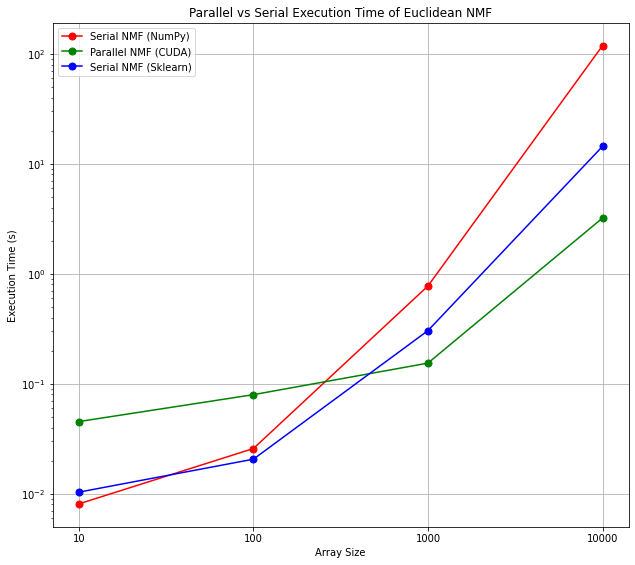

In [25]:
title = "Parallel vs Serial Execution Time of Euclidean NMF" # define plot title

# generate plot
plot_execution_times(execution_times_parallel,  
                     execution_times_serial, 
                     execution_times_sklearn, 
                     title,
                     input_sizes)

## NMF with KL Divergence Multiplicative Updates

### Serial KL Divergence NMF with Python

In [40]:
# define number of topics to extract from data
num_topics = 25

# define X, W, H matrices
X, W, H = get_matrices(num_topics)

W_serial_kl, H_serial_kl, losses_serial_kl, time_serial_kl = NMF_serial(X, W, H, loss='divergence')

print("{} iterations of serial KL Divergence NMF completed in {} s.".format(num_iterations, round(time_serial_kl, 3)))

Starting 100 iterations of serial NMF with divergence loss.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of serial KL Divergence NMF completed in 119.835 s.


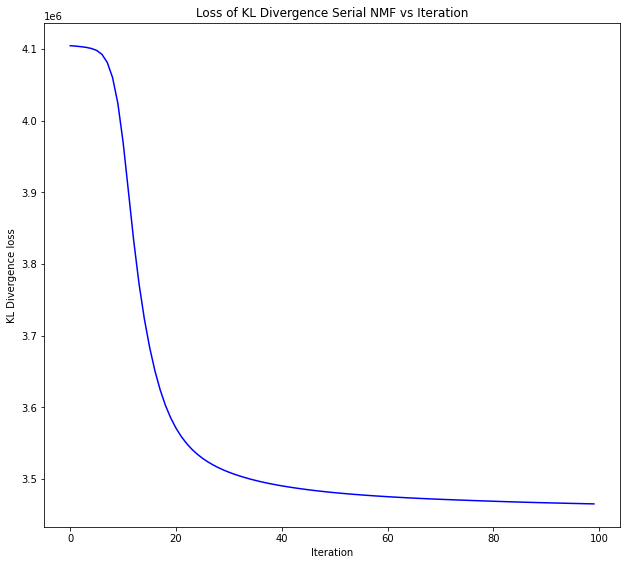

In [41]:
# visualize loss
title = "Loss of KL Divergence Serial NMF vs Iteration"
plot_loss(losses_serial_kl, title, loss_type='KL Divergence')

In [42]:
# Visualize results
get_topics(W_serial_kl, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0243 sell,0.0308 school,0.0311 police,0.0557 father,0.0115 cause,0.0157 official,0.0163 pay,0.0206 food,0.0231 music,0.0371 team,...,0.0204 art,0.0123 design,0.0197 country,0.0182 television,0.0155 mile,0.0393 company,0.0178 thing,0.0179 case,0.0241 win,0.0212 campaign
1,0.0203 sale,0.0259 student,0.0191 kill,0.0465 son,0.0098 problem,0.0120 military,0.0154 money,0.0113 fresh,0.0197 play,0.0249 player,...,0.0126 artist,0.0100 color,0.0164 government,0.0069 network,0.0118 travel,0.0212 executive,0.0133 feel,0.0157 court,0.0208 second,0.0171 vote
2,0.0184 company,0.0122 child,0.0183 officer,0.0437 mrs,0.0090 damage,0.0118 american,0.0138 state,0.0108 serve,0.0149 performance,0.0244 season,...,0.0093 history,0.0095 wall,0.0160 political,0.0068 video,0.0106 hour,0.0154 business,0.0130 ask,0.0155 lawyer,0.0166 play,0.0144 political
3,0.0179 store,0.0118 program,0.0158 man,0.0386 mother,0.0073 plant,0.0109 states,0.0128 budget,0.0098 pound,0.0101 perform,0.0237 game,...,0.0090 century,0.0091 display,0.0112 american,0.0066 medium,0.0106 town,0.0145 president,0.0126 lot,0.0140 law,0.0164 game,0.0142 election
4,0.0173 buy,0.0118 class,0.0153 charge,0.0362 daughter,0.0073 water,0.0094 war,0.0128 bill,0.0096 eat,0.0100 stage,0.0192 play,...,0.0080 image,0.0071 room,0.0108 policy,0.0063 computer,0.0104 car,0.0131 chief,0.0114 tell,0.0111 judge,0.0152 victory,0.0141 candidate
5,0.0130 price,0.0109 education,0.0135 crime,0.0286 graduate,0.0070 official,0.0087 force,0.0109 tax,0.0090 restaurant,0.0099 production,0.0159 coach,...,0.0072 american,0.0065 small,0.0105 states,0.0061 program,0.0099 city,0.0109 share,0.0110 really,0.0097 legal,0.0137 score,0.0136 party
6,0.0121 business,0.0108 college,0.0131 arrest,0.0260 family,0.0066 report,0.0080 meeting,0.0102 program,0.0088 taste,0.0099 theater,0.0123 baseball,...,0.0071 culture,0.0064 glass,0.0104 nation,0.0060 movie,0.0094 trip,0.0101 chairman,0.0093 little,0.0087 issue,0.0132 third,0.0131 republican
7,0.0108 cost,0.0093 group,0.0123 death,0.0246 marry,0.0057 scientist,0.0078 government,0.0098 cut,0.0086 dry,0.0099 dance,0.0115 league,...,0.0070 world,0.0064 light,0.0103 leader,0.0059 screen,0.0087 road,0.0087 yesterday,0.0090 happen,0.0080 rule,0.0123 point,0.0103 democratic
8,0.0107 industry,0.0089 teacher,0.0117 official,0.0206 receive,0.0055 safety,0.0069 nations,0.0095 plan,0.0083 cook,0.0095 song,0.0094 contract,...,0.0070 exhibition,0.0064 red,0.0100 power,0.0058 create,0.0086 train,0.0087 announce,0.0087 put,0.0077 charge,0.0104 lose,0.0091 voter
9,0.0105 customer,0.0088 community,0.0102 victim,0.0205 retire,0.0054 system,0.0069 agreement,0.0092 cost,0.0082 fish,0.0095 audience,0.0092 football,...,0.0069 photograph,0.0062 open,0.0088 economic,0.0056 different,0.0084 drive,0.0086 financial,0.0082 keep,0.0076 state,0.0101 final,0.0091 support


### Serial KL Divergence NMF with Scikit-Learn

In [43]:
start = time.time() # record start time

# define NMF model in sklearn with same parameters
num_sklearn_iterations = 1000
# NOTE: change num_iterations --> num_sklearn_iterations to see execution time to sufficient convergence
model_kl = NMF(n_components=num_topics, init='custom', beta_loss='kullback-leibler', max_iter=num_iterations, solver='mu', tol=1e-10)
W_sklearn_kl = model_kl.fit_transform(X, W=W, H=H)
H_sklearn_kl = model_kl.components_

end = time.time()
time_sklearn_kl = end - start

print("{} iterations of sklearn Euclidean NMF completed in {} s.".format(num_iterations, round(time_sklearn_kl, 3)))


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


100 iterations of sklearn Euclidean NMF completed in 45.33 s.


In [44]:
# Visualize results
get_topics(W_sklearn_kl, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0306 percent,0.0316 school,0.0277 police,0.0534 father,0.0266 report,0.0161 military,0.0179 pay,0.0117 water,0.0201 play,0.0388 team,...,0.0172 music,0.0154 food,0.0187 political,0.0110 thing,0.0123 city,0.0368 company,0.0149 wait,0.0172 case,0.0271 win,0.0201 states
1,0.0187 price,0.0264 student,0.0194 charge,0.0445 son,0.0137 official,0.0143 war,0.0164 money,0.0117 plant,0.0158 thing,0.0277 season,...,0.0133 art,0.0096 serve,0.0184 campaign,0.0085 great,0.0121 town,0.0207 executive,0.0135 ask,0.0154 court,0.0235 second,0.0181 american
2,0.0181 rate,0.0120 class,0.0153 officer,0.0419 mrs,0.0109 appear,0.0123 government,0.0146 state,0.0088 air,0.0119 lot,0.0274 game,...,0.0109 play,0.0093 restaurant,0.0183 vote,0.0081 question,0.0114 visit,0.0174 business,0.0131 tell,0.0152 law,0.0164 victory,0.0153 country
3,0.0179 market,0.0118 child,0.0150 man,0.0397 mother,0.0106 number,0.0113 force,0.0130 budget,0.0083 plane,0.0109 guy,0.0239 player,...,0.0096 artist,0.0090 fresh,0.0138 party,0.0078 mean,0.0090 mile,0.0138 president,0.0127 walk,0.0141 lawyer,0.0164 score,0.0151 policy
4,0.0152 rise,0.0114 education,0.0124 crime,0.0347 daughter,0.0106 problem,0.0109 leader,0.0115 bill,0.0083 car,0.0106 young,0.0169 coach,...,0.0093 performance,0.0084 taste,0.0135 election,0.0077 put,0.0089 home,0.0124 chief,0.0114 start,0.0110 legal,0.0162 play,0.0125 editor
5,0.0114 economy,0.0111 program,0.0120 arrest,0.0273 graduate,0.0097 condition,0.0088 american,0.0113 tax,0.0081 flight,0.0105 tell,0.0167 play,...,0.0076 director,0.0079 dry,0.0133 candidate,0.0073 far,0.0086 live,0.0122 share,0.0107 feel,0.0109 rule,0.0150 game,0.0115 government
6,0.0109 increase,0.0106 college,0.0108 official,0.0259 family,0.0095 release,0.0087 official,0.0107 cost,0.0076 gas,0.0087 really,0.0127 league,...,0.0076 theater,0.0074 dinner,0.0132 republican,0.0072 point,0.0084 local,0.0100 sell,0.0100 decide,0.0107 judge,0.0148 third,0.0101 official
7,0.0103 low,0.0105 group,0.0101 criminal,0.0236 marry,0.0095 accord,0.0085 peace,0.0105 program,0.0070 vehicle,0.0087 watch,0.0126 baseball,...,0.0075 stage,0.0073 eat,0.0124 leader,0.0067 kind,0.0082 travel,0.0096 chairman,0.0090 thing,0.0099 issue,0.0139 point,0.0091 nation
8,0.0100 fall,0.0094 community,0.0100 kill,0.0197 retire,0.0092 continue,0.0079 country,0.0103 cut,0.0070 cause,0.0086 little,0.0094 football,...,0.0074 production,0.0072 cook,0.0109 democratic,0.0066 certainly,0.0078 car,0.0092 financial,0.0087 stay,0.0094 decision,0.0121 final,0.0086 foreign
9,0.0092 growth,0.0094 teacher,0.0094 yesterday,0.0195 receive,0.0092 occur,0.0073 nations,0.0102 plan,0.0069 safety,0.0085 hear,0.0089 contract,...,0.0073 audience,0.0071 add,0.0099 support,0.0066 different,0.0076 hour,0.0088 firm,0.0086 job,0.0088 state,0.0111 lose,0.0082 threat


### Parallel KL Divergence NMF with CUDA

In [7]:
W_parallel_kl, H_parallel_kl, time_parallel_kl = NMF_parallel(X, W, H, loss='divergence')

print("{} iterations of parallel Euclidean NMF completed in {} s.".format(num_iterations, round(time_parallel_kl, 3)))

Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of parallel Euclidean NMF completed in 1.466 s.


In [8]:
# Visualize results
get_topics(W_parallel_kl, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0243 sell,0.0308 school,0.0311 police,0.0557 father,0.0115 cause,0.0157 official,0.0163 pay,0.0206 food,0.0231 music,0.0371 team,...,0.0204 art,0.0123 design,0.0197 country,0.0182 television,0.0155 mile,0.0393 company,0.0178 thing,0.0179 case,0.0241 win,0.0212 campaign
1,0.0203 sale,0.0259 student,0.0191 kill,0.0465 son,0.0098 problem,0.0120 military,0.0154 money,0.0113 fresh,0.0197 play,0.0249 player,...,0.0126 artist,0.0100 color,0.0164 government,0.0069 network,0.0118 travel,0.0212 executive,0.0133 feel,0.0157 court,0.0208 second,0.0171 vote
2,0.0184 company,0.0122 child,0.0183 officer,0.0437 mrs,0.0090 damage,0.0118 american,0.0138 state,0.0108 serve,0.0149 performance,0.0244 season,...,0.0093 history,0.0095 wall,0.0160 political,0.0068 video,0.0106 hour,0.0154 business,0.0130 ask,0.0155 lawyer,0.0166 play,0.0144 political
3,0.0179 store,0.0118 program,0.0158 man,0.0386 mother,0.0073 plant,0.0109 states,0.0128 budget,0.0098 pound,0.0101 perform,0.0237 game,...,0.0090 century,0.0091 display,0.0112 american,0.0066 medium,0.0106 town,0.0145 president,0.0126 lot,0.0140 law,0.0164 game,0.0142 election
4,0.0173 buy,0.0118 class,0.0153 charge,0.0362 daughter,0.0073 water,0.0093 war,0.0128 bill,0.0096 eat,0.0100 stage,0.0192 play,...,0.0080 image,0.0071 room,0.0108 policy,0.0063 computer,0.0104 car,0.0131 chief,0.0114 tell,0.0111 judge,0.0152 victory,0.0141 candidate
5,0.0130 price,0.0109 education,0.0135 crime,0.0286 graduate,0.0070 official,0.0087 force,0.0109 tax,0.0090 restaurant,0.0099 production,0.0159 coach,...,0.0072 american,0.0065 small,0.0105 states,0.0061 program,0.0099 city,0.0109 share,0.0110 really,0.0097 legal,0.0137 score,0.0136 party
6,0.0121 business,0.0108 college,0.0131 arrest,0.0260 family,0.0066 report,0.0080 meeting,0.0102 program,0.0088 taste,0.0099 theater,0.0123 baseball,...,0.0071 culture,0.0064 glass,0.0104 nation,0.0060 movie,0.0094 trip,0.0101 chairman,0.0093 little,0.0087 issue,0.0132 third,0.0131 republican
7,0.0108 cost,0.0093 group,0.0123 death,0.0246 marry,0.0057 scientist,0.0078 government,0.0098 cut,0.0086 dry,0.0099 dance,0.0115 league,...,0.0070 world,0.0064 light,0.0103 leader,0.0059 screen,0.0087 road,0.0087 yesterday,0.0090 happen,0.0080 rule,0.0123 point,0.0103 democratic
8,0.0107 industry,0.0089 teacher,0.0117 official,0.0206 receive,0.0055 safety,0.0069 nations,0.0095 plan,0.0083 cook,0.0095 song,0.0094 contract,...,0.0070 exhibition,0.0064 red,0.0100 power,0.0058 create,0.0086 train,0.0087 announce,0.0087 put,0.0077 charge,0.0104 lose,0.0091 voter
9,0.0105 customer,0.0088 community,0.0102 victim,0.0205 retire,0.0054 system,0.0069 agreement,0.0092 cost,0.0082 fish,0.0095 audience,0.0092 football,...,0.0069 photograph,0.0062 open,0.0088 economic,0.0056 different,0.0084 drive,0.0086 financial,0.0082 keep,0.0076 state,0.0101 final,0.0091 support


## Visualize Time Differences

In [27]:
input_sizes = [10**i for i in range(1, 5)] # define range of input sizes
# input_sizes = [10**i for i in range(1, 4)] # define range of input sizes


K = 25 # define learnable dimension size parameter

execution_times_parallel = [] # initialize execution time lists
execution_times_serial = []
execution_times_sklearn = []

for input_size in input_sizes: # iterate over input sizes
    input_shape = (input_size, input_size)
    X, W, H = get_n_matrices(K, input_shape) # generate random X, W, H matrices of size input_shape
    W_p, H_p, ex_time_parallel = NMF_parallel(X, W, H, print_iterations=False, loss='divergence') # call parallel NMF
    W_s, H_s, _, ex_time_serial = NMF_serial(X, W, H, print_iterations=False, loss='divergence') # call sequential NMF
    W_sk, H_sk, ex_time_sklearn = NMF_sklearn(X, W, H, loss='divergence') # call sklearn NMF
    

    execution_times_parallel.append(ex_time_parallel) # store execution times
    execution_times_serial.append(ex_time_serial)
    execution_times_sklearn.append(ex_time_sklearn)    

Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.
Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.
Starting 100 iterations of parallel NMF with divergence multiplicative updates.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


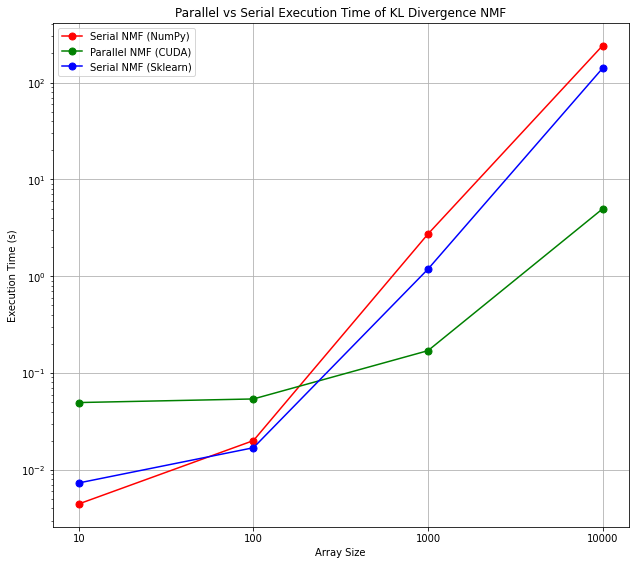

In [28]:
title = "Parallel vs Serial Execution Time of KL Divergence NMF" # define plot title

# generate plot
plot_execution_times(execution_times_parallel,  
                     execution_times_serial, 
                     execution_times_sklearn, 
                     title,
                     input_sizes)